# Regression example using TF-MELT
This is a basic regression example using the models in TF-MELT.

Requires the following additional packages:
* ipykernel
* scikit-learn
* matplotlib

In [72]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [73]:
# Use sklearn scaling libraries to normalize the data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x_normalizer = StandardScaler()
y_normalizer = StandardScaler()

x_normalizer.fit(x)
y_normalizer.fit(y)

x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

## Artificial Neural Network (ANN)
Create and train an ANN using TF-MELT.

In [74]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Set the hyperparameters
loss = "mse"
learn_rate = 1e-3

# Create the model
model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=8,
    depth=2,
    act_fun="relu",
    l1_reg=1e-3,
    l2_reg=1e-3,
    input_dropout=0.1,
    dropout=0.2,
    batch_norm=True,
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
model.build(input_shape=(None, n_features))
model.summary()


Model: "artificial_neural_network_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 input_dropout (Dropout)     multiple                  0         
                                                                 
 batch_norm_0 (BatchNormaliz  multiple                 32        
 ation)                                                          
                                                                 
 batch_norm_1 (BatchNormaliz  multiple                 32        
 ation)                                                          
                                                                 
 batch_norm_2 (BatchNormaliz  multiple

In [75]:
# Train the model
history = model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=100, 
    batch_size=32,
    shuffle=True,
)

Epoch 1/100
25/25 [==============================] - 1s 7ms/step - loss: 1.2332 - val_loss: 1.5725
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 1.0517 - val_loss: 1.4090
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.9602 - val_loss: 1.2993
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.8890 - val_loss: 1.1774
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.8163 - val_loss: 1.0659
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.7335 - val_loss: 0.9093
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6455 - val_loss: 0.7764
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5618 - val_loss: 0.6286
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4830 - val_loss: 0.5181
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4143 - val_loss: 0.4213
Epoch 11/

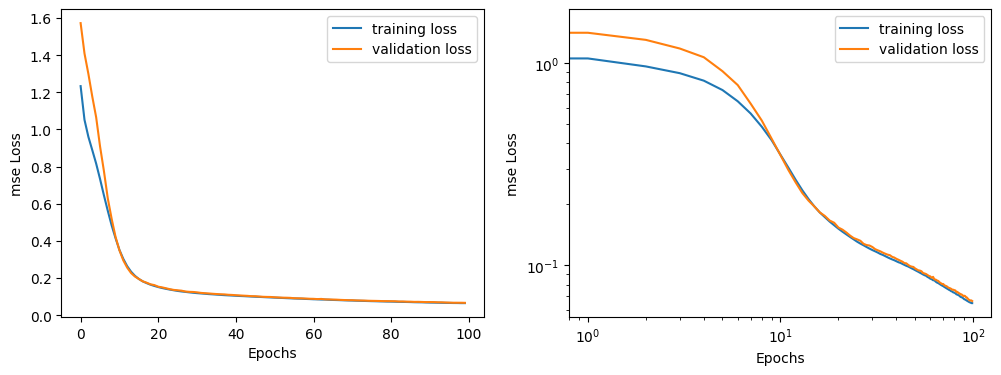

In [76]:
# Plot the loss function over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["loss"], label="training loss")
ax1.plot(history.history["val_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel(f"{loss} Loss")

ax2.loglog(history.history["loss"], label="training loss")
ax2.loglog(history.history["val_loss"], label="validation loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel(f"{loss} Loss")
plt.show()

In [77]:
# Evaluate the model performance on train and validation data
pred_norm = model(x_norm, training=False)
pred_norm_train = model(x_train, training=False)
pred_norm_val = model(x_val, training=False)
pred_norm_test = model(x_test, training=False)

# Unscale the results and plot
pred_full = y_normalizer.inverse_transform(pred_norm)
pred_train = y_normalizer.inverse_transform(pred_norm_train)
pred_val = y_normalizer.inverse_transform(pred_norm_val)
pred_test = y_normalizer.inverse_transform(pred_norm_test)

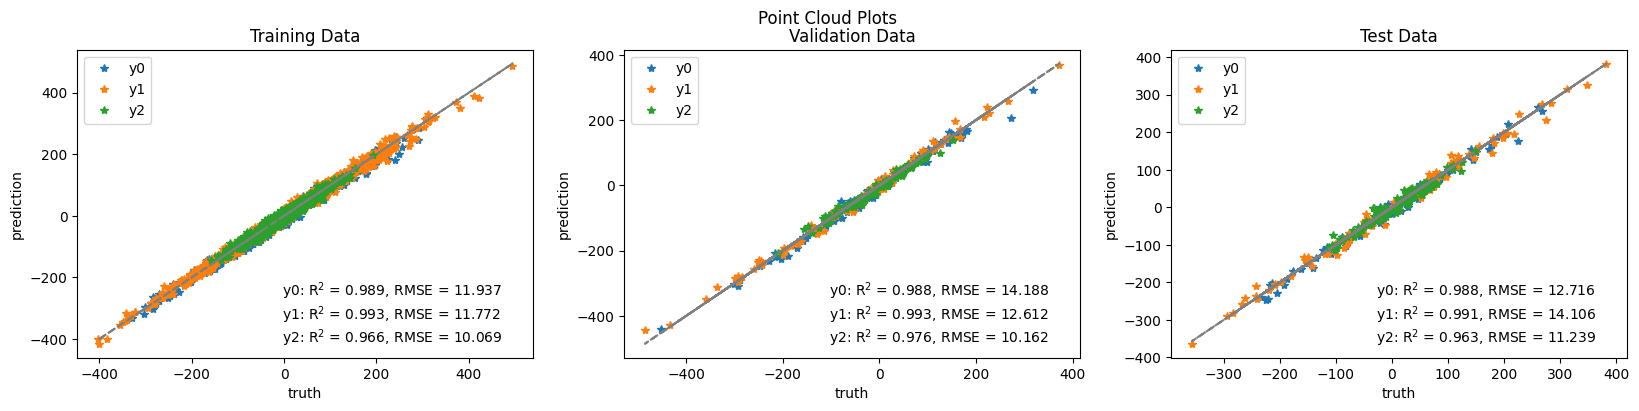

In [78]:
# Compute some statistics on the fit
import numpy as np

def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/(truth+1e-6))**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# Train plot
for i in range(n_targets):
    ax1.plot(y_train_real[:, i], pred_train[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    # Validation plot
    ax2.plot(y_val_real[:, i], pred_val[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    # Test plot
    ax3.plot(y_test_real[:, i], pred_test[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()